In [1]:
import sys
import os

#data format library
import numpy as np
import matplotlib.pyplot as plt

repo_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(repo_path)

from scipy.integrate import odeint

import src

colors_state_ = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('text', usetex=False)
plt.rc('font', size=14)

/home/dendun/miniconda3/envs/long-time-worm/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dendun/miniconda3/envs/long-time-worm/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dendun/miniconda3/envs/long-time-worm/lib/pyth

In [2]:
# Generate Lorenz Data

def Lorenz(state, t, sigma, rho, beta):
    # unpack the state vector
    x, y, z = state
    # compute state derivatives
    xd = sigma * (y - x)
    yd = (rho - z) * x - y
    zd = x * y - beta * z
    # return the state derivatives
    return [xd, yd, zd]


dt = 0.02
frameRate = 1 / dt
T = 2000
discard_T = 100
T_total = T + discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total * frameRate))
sigma, rho, beta = 10, 28, 8 / 3
tseries = np.array(odeint(Lorenz, state0, t, args=(sigma, rho, beta)), dtype=np.float64)[int(discard_T / dt):]

print(f"{tseries.shape=}")

tseries.shape=(100000, 3)


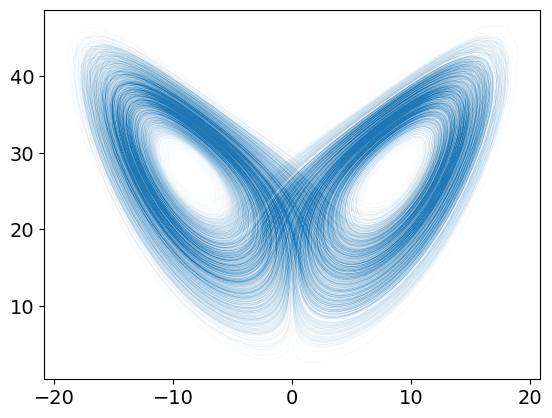

In [3]:
plt.plot(tseries[:, 0], tseries[:, 2], lw=.02)
plt.show()

# Compute predictability as a function of delay

In [4]:
X = tseries[:, 0].reshape((tseries.shape[0], 1))  # take x variable only
print(f"{X.shape=}")

X.shape=(100000, 1)


In [5]:
# to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seed_range = np.array(np.logspace(2, 3, 4), dtype=int)  # number of partitions to examine
print(f"{n_seed_range=}")
range_Ks = np.arange(2, 16, 2, dtype=int)  #range of delays to study
print(f"{range_Ks=}")
h_K = np.zeros((len(range_Ks), len(n_seed_range)))
for k, K in enumerate(range_Ks):
    # traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X), K=K - 1)
    traj_matrix = src.mps.time_delay_embedding.time_delay_embedding(X, delay=K - 1)
    for ks, n_seeds in enumerate(n_seed_range):
        # labels = cl.kmeans_knn_partition(traj_matrix, n_seeds)
        labels, cluster_centers, kmeans = src.mps.clustering.cluster_data(traj_matrix, n_clusters=n_seeds,
                                                                          return_centers=True, random_state=42)
        # h = op_calc.get_entropy(labels)
        # Directed
        transition_matrix = src.mps.markov.get_transition_matrix(labels, lag=1, directed=True)
        h = src.mps.markov.get_entropy_rate(transition_matrix)
        h_K[k, ks] = h

        print('Computed for {} delays and {} seeds.'.format(K, n_seeds))

n_seed_range=array([ 100,  215,  464, 1000])
range_Ks=array([ 2,  4,  6,  8, 10, 12, 14])
Computed for 2 delays and 100 seeds.
Computed for 2 delays and 215 seeds.
Computed for 2 delays and 464 seeds.
Computed for 2 delays and 1000 seeds.
Computed for 4 delays and 100 seeds.
Computed for 4 delays and 215 seeds.
Computed for 4 delays and 464 seeds.
Computed for 4 delays and 1000 seeds.
Computed for 6 delays and 100 seeds.
Computed for 6 delays and 215 seeds.
Computed for 6 delays and 464 seeds.
Computed for 6 delays and 1000 seeds.
Computed for 8 delays and 100 seeds.
Computed for 8 delays and 215 seeds.
Computed for 8 delays and 464 seeds.
Computed for 8 delays and 1000 seeds.
Computed for 10 delays and 100 seeds.
Computed for 10 delays and 215 seeds.
Computed for 10 delays and 464 seeds.
Computed for 10 delays and 1000 seeds.
Computed for 12 delays and 100 seeds.
Computed for 12 delays and 215 seeds.
Computed for 12 delays and 464 seeds.
Computed for 12 delays and 1000 seeds.
Computed

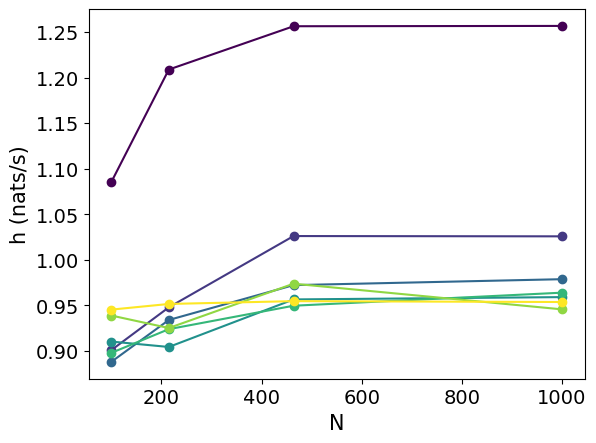

In [6]:
colors_K = plt.cm.viridis(np.linspace(0, 1, len(range_Ks)))
for k, K in enumerate(range_Ks):
    plt.plot(n_seed_range, h_K[k], c=colors_K[k], marker='o')
plt.xlabel('N', fontsize=15)
plt.ylabel('h (nats/s)', fontsize=15)
plt.show()

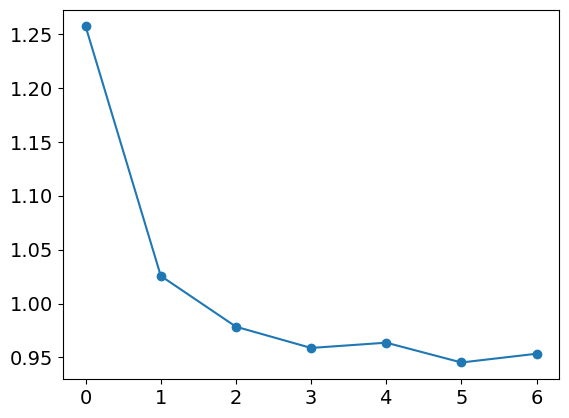

In [7]:
plt.plot(h_K[:, 3], marker='o')
plt.show()

In [8]:
K_star = 12
traj_matrix = src.mps.time_delay_embedding.time_delay_embedding(X, delay=K_star - 1)
print(f"{traj_matrix.shape=}")

traj_matrix.shape=(99989, 12)


# Estimate implied time scales of the reversibilized operator

In [9]:
# to get error estimates in the manuscript we split the trajectory into non-overlapping segments
import deeptime as dtime

n_seeds = 1000
# n_modes=10

# labels = ma.array(cl.kmeans_knn_partition(traj_matrix, n_seeds), dtype=int)
labels, cluster_centers, kmeans = src.mps.clustering.cluster_data(traj_matrix,
                                                                  n_clusters=n_seeds,
                                                                  return_centers=True,
                                                                  random_state=None)

delay_range = np.arange(1, 20, 1)
n_modes = 5
ts_traj = np.zeros((len(delay_range), n_modes))
ts_traj_dtime = np.zeros((len(delay_range), n_modes))
for kd, delay in enumerate(delay_range):
    print(delay)
    P = src.mps.markov.get_transition_matrix(labels, lag=delay, directed=True)
    R = src.mps.markov.get_reversible_transition_matrix(P)
    ts_traj[kd, :] = src.mps.markov.get_timescales(R, delay, dt, k=n_modes + 1, which="LR", sort_by="R")
    ts_traj_dtime[kd, :] = dtime.markov.tools.analysis.timescales(T=R,
                                                                  tau=delay * dt,
                                                                  k=n_modes + 1,
                                                                  reversible=False)[1:]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


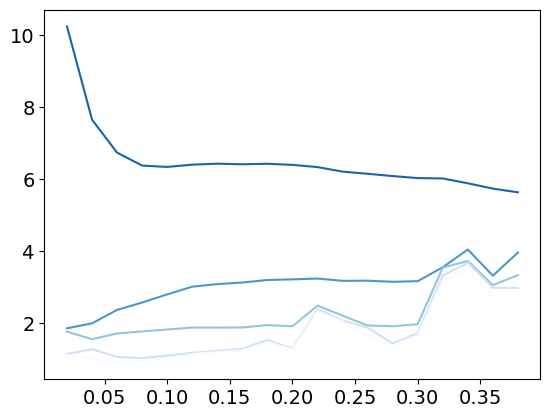

In [10]:
colors_modes = plt.cm.Blues_r(np.linspace(0.2, 1, n_modes))
for km in range(n_modes):
    plt.plot(delay_range * dt, ts_traj[:, km], c=colors_modes[km])
plt.show()

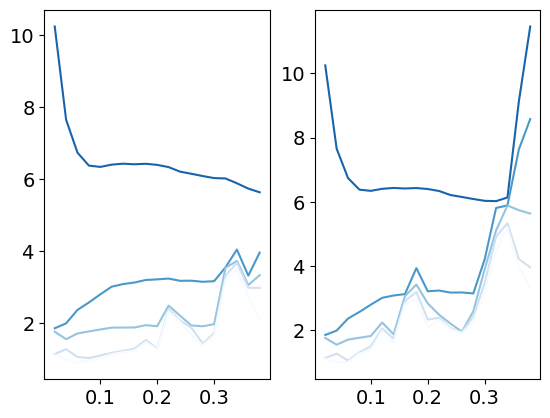

In [11]:
plt.subplot(121)
colors_modes = plt.cm.Blues_r(np.linspace(0.2, 1, n_modes))
for km in range(n_modes):
    plt.plot(delay_range * dt, ts_traj[:, km], c=colors_modes[km])

plt.subplot(122)
colors_modes = plt.cm.Blues_r(np.linspace(0.2, 1, n_modes))
for km in range(n_modes):
    plt.plot(delay_range * dt, ts_traj_dtime[:, km], c=colors_modes[km])

In [19]:
delay = 10
print(delay * dt)
# P = op_calc.transition_matrix(labels, delay)
# R = op_calc.get_reversible_transition_matrix(P)
P = src.mps.markov.get_transition_matrix(labels, lag=delay, directed=True)
R = src.mps.markov.get_reversible_transition_matrix(P)
eigvals, eigvecs = src.mps.markov.get_eigenspectrum(R, k=10)

# eigenvectors = dtime.markov.tools.analysis.eigenvectors(T=R,
#                                                         k=n_modes,
#                                                         reversible=False)

print(eigvals)

0.2
[1.        +0.j 0.96922931+0.j 0.93969697+0.j 0.90073143+0.j
 0.85597377+0.j 0.85335729+0.j 0.84758147+0.j 0.83942503+0.j
 0.83803359+0.j 0.82785938+0.j]


In [20]:
u, s, v = np.linalg.svd(traj_matrix, full_matrices=False)

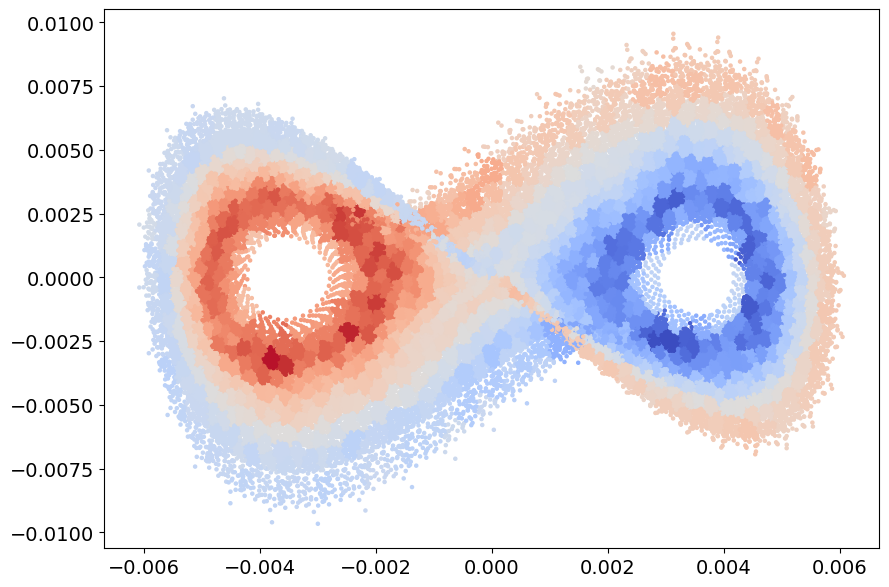

In [23]:
phi2 = eigvecs[labels, 1].real
plt.figure(figsize=(10, 7))
color_abs = np.max(np.abs(phi2))
plt.scatter(u[:, 0], u[:, 1], c=phi2, cmap='coolwarm', s=5, vmin=-color_abs, vmax=color_abs)
plt.show()

0.2s


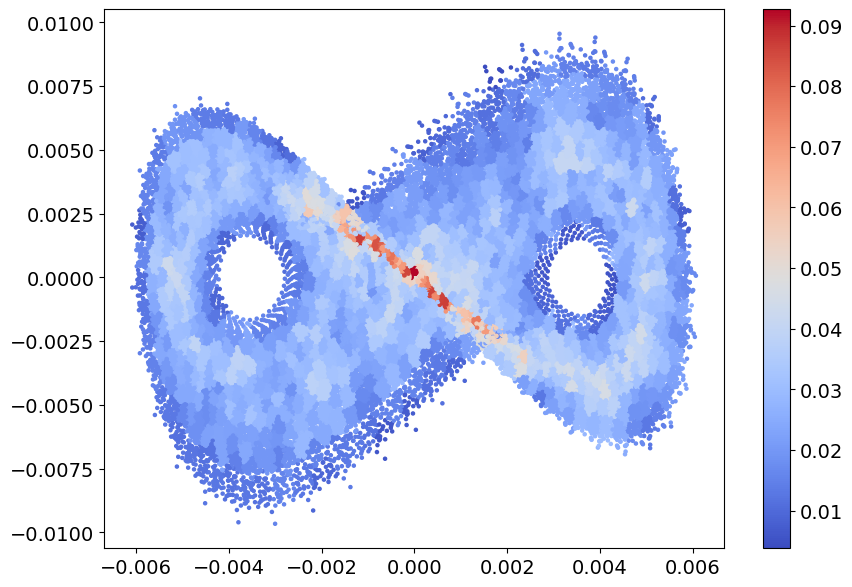

np.min(np.abs(phi1)), np.max(np.abs(phi1))=(0.0038017789116932947, 0.09268132208139414)


In [15]:
# Stationary distribution from eigenvectors: 
delay = 10
print(f"{delay * dt}s")
P = src.mps.markov.get_transition_matrix(labels, lag=delay, directed=True)
R = src.mps.markov.get_reversible_transition_matrix(P)
eigvals, eigvecs = src.mps.markov.get_eigenspectrum(R, k=5)

phi1 = eigvecs[labels, 0].real
plt.figure(figsize=(10, 7))
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=5, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.show()

print(f"{np.min(np.abs(phi1)), np.max(np.abs(phi1))=}")

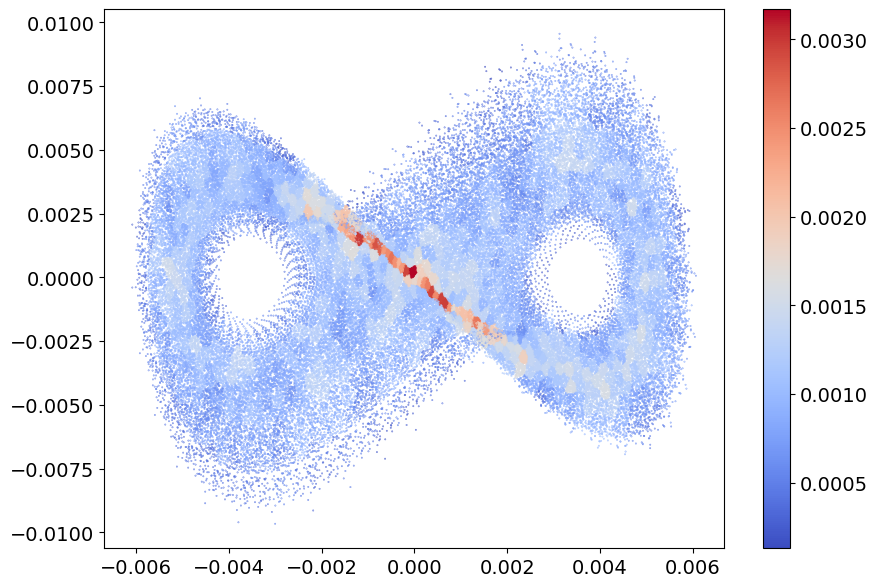

(0.00013004430152106547, 0.003170273199489023)


In [16]:
# Stationary distribution
stat_dist = src.mps.markov.get_stationary_distribution(R, mode="eigenvector") 
phi1 = stat_dist[labels]
plt.figure(figsize=(10, 7))
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=.1, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.show()
print(f"{np.min(np.abs(phi1)), np.max(np.abs(phi1))}")

In [25]:
r, d, l = dtime.markov.tools.analysis.rdl_decomposition(R, k=5) 
print(f"{r.shape, d.shape, l.shape=}")

r.shape, d.shape, l.shape=((1000, 5), (5, 5), (5, 1000))


In [27]:
r

array([[ 1.        +0.j,  1.39814655+0.j, -0.53478143+0.j,
        -0.51506089+0.j,  1.49009497+0.j],
       [ 1.        +0.j, -1.81667498+0.j, -1.85254145+0.j,
         0.28076569+0.j, -0.02514311+0.j],
       [ 1.        +0.j,  0.85796208+0.j,  0.36419557+0.j,
        -1.65088993+0.j, -0.33563768+0.j],
       ...,
       [ 1.        +0.j, -1.03013361+0.j, -0.40996172+0.j,
         0.89297869+0.j,  0.26899765+0.j],
       [ 1.        +0.j, -0.10859526+0.j,  0.68782757+0.j,
         1.24455302+0.j, -1.08351619+0.j],
       [ 1.        +0.j,  0.814369  +0.j,  0.23230229+0.j,
         0.83069004+0.j, -1.63459054+0.j]])

(5.936223734792634e-15+0j)


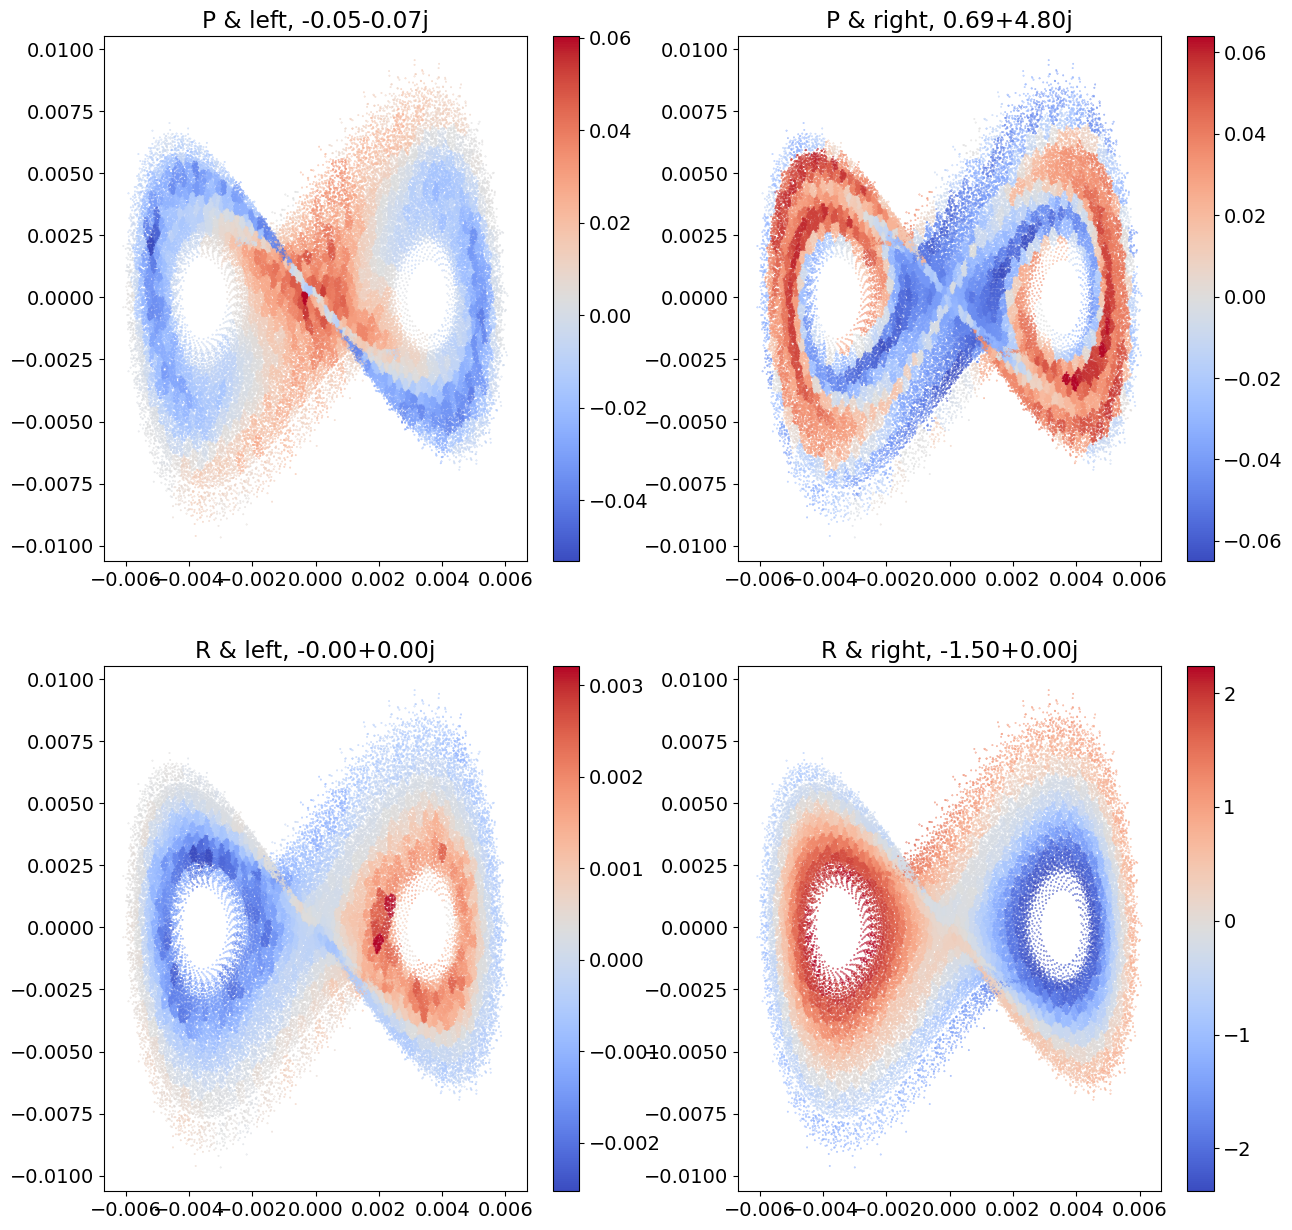

(3.671091383097867e-07, 0.0032077556127863083)


In [57]:
# Stationary distribution
P = src.mps.markov.get_transition_matrix(labels, lag=delay, directed=True)
R = src.mps.markov.get_reversible_transition_matrix(P)


i = 1
plt.figure(figsize=(15, 15))


plt.subplot(222)
tm_use = P
r, d, l = dtime.markov.tools.analysis.rdl_decomposition(tm_use, k=5) 
phi1 = r[:, i][labels]
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=.1, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.title(f"P & right, {np.sum(r[:, i]):.2f}")

plt.subplot(221)
tm_use = P
r, d, l = dtime.markov.tools.analysis.rdl_decomposition(tm_use, k=5) 
phi1 = l[i, :][labels]
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=.1, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.title(f"P & left, {np.sum(l[:, i]):.2f}")

plt.subplot(224)
tm_use = R
r, d, l = dtime.markov.tools.analysis.rdl_decomposition(tm_use, k=5) 
phi1 = r[:, i][labels]
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=.1, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.title(f"R & right, {np.sum(r[:, i]):.2f}")

plt.subplot(223)
tm_use = R
r, d, l = dtime.markov.tools.analysis.rdl_decomposition(tm_use, k=5) 
print(np.sum(l[i, :]))
phi1 = l[i, :][labels]
color_abs = np.max(np.abs(phi1))
plt.scatter(u[:, 0], u[:, 1], c=phi1, cmap='coolwarm', s=.1, 
            # vmin=-color_abs, vmax=color_abs
            )
plt.colorbar()
plt.title(f"R & left, {np.sum(l[:, i]):.2f}")


plt.show()
print(f"{np.min(np.abs(phi1)), np.max(np.abs(phi1))}")

In [58]:
d

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.9687953 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.93819921,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.93242451,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.91580953]])